## Load and Preprocess

In [1]:
import pickle
import csv
import unicodedata

import numpy as np
import pandas as pd


from gensim.utils import simple_preprocess
from gensim import corpora, models, similarities
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import PolynomialFeatures
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

import itertools
import nltk
import gensim
import spacy
import gensim.corpora as corpora

from nltk.util import ngrams
from itertools import chain
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score

import pyLDAvis.gensim
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


In [2]:
df = pd.read_excel('TED Talks as of 3.29.2018.xlsx')

In [3]:
# Transform TED data set

df=df.dropna()

# Add target 
df['tags_list'] = df['tags'].str.split(',')  

In [4]:
#Select most popular TED categories and pick the first category listed in the tags column for each observation

categories = ['global issues','design','entertainment', 'technology', 'business','science']

def pick_cat(tags_list):
    for tag in tags_list:
        if tag in categories:
            return tag
    return None

df['category'] = df['tags_list'].apply(pick_cat)                                  

In [5]:
pd.options.display.max_columns = None
display.max_colwidth = 50
display.width = 70
#FOR NOW REMOVE UNCATEGORIZED ROWS
df1 = df.dropna()
df1.head(5)

Talk ID                                         public_url   speaker_name  \
0        1  https://www.ted.com/talks/al_gore_on_averting_...        Al Gore   
1        7  https://www.ted.com/talks/david_pogue_says_sim...    David Pogue   
2       53  https://www.ted.com/talks/majora_carter_s_tale...  Majora Carter   
4       92  https://www.ted.com/talks/hans_rosling_shows_t...   Hans Rosling   
5       96  https://www.ted.com/talks/tony_robbins_asks_wh...   Tony Robbins   

                          headline  \
0      Averting the climate crisis   
1                 Simplicity sells   
2              Greening the ghetto   
4  The best stats you've ever seen   
5             Why we do what we do   

                                         description    event  duration  \
0  With the same humor and humanity he exuded in ...  TED2006  00:16:17   
1  New York Times columnist David Pogue takes aim...  TED2006  00:21:26   
2  In an emotionally charged talk, MacArthur-winn...  TED2006  00:18:36   
4  You've never seen data presented like this. Wi...  TED2006  00:19:50   
5  Tony Robbins discusses the "invisible forces" ...  TED2006  00:21:45   

  language  published                                               tags  \
0       en 2006-06-27  alternative energy,cars,global issues,climate ...   
1       en 2006-06-27  simplicity,entertainment,interface design,soft...   
2       en 2006-06-27  MacArthur grant,cities,green,activism,politics...   
4       en 2006-06-27  demo,Asia,global issues,visualizations,global ...   
5       en 2006-06-27  entertainment,goal-setting,potential,psycholog...   

                                           tags_list       category  
0  [alternative energy, cars, global issues, clim...  global issues  
1  [simplicity, entertainment, interface design, ...  entertainment  
2  [MacArthur grant, cities, green, activism, pol...       business  
4  [demo, Asia, global issues, visualizations, gl...  global issues  
5  [entertainment, goal-setting, potential, psych...  entertainment

In [6]:
df1['category'] = pd.Categorical(df1['category'])
df1['code'] = df1['category'].cat.codes
# categories = ['global issues','design','entertainment', 'technology', 'business','science']
# codes = [3,1,2,5,0,4]
df1[df1['speaker_name'] == 'Jamie Oliver']

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Talk ID                              public_url  speaker_name  \
614      765  https://www.ted.com/talks/jamie_oliver  Jamie Oliver   

                         headline  \
614  Teach every child about food   

                                           description    event  duration  \
614  Sharing powerful stories from his anti-obesity...  TED2010  00:21:53   

    language  published                                               tags  \
614       en 2010-02-11  obesity,global issues,food,health,business,edu...   

                                             tags_list       category  code  
614  [obesity, global issues, food, health, busines...  global issues     3

In [33]:
1.00* df1['category'].value_counts()/sum(df1['category'].value_counts())

global issues    0.245784
science          0.234543
design           0.177823
entertainment    0.152785
technology       0.096576
business         0.092489
Name: category, dtype: float64

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ljborton/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
stop = stopwords.words('english')

In [9]:
ted_stop=['like','ted','could','to_the',  'part', 'use', 'story', 'make', 'fellow', 'ted_fellow', 'around', 
          'more_about', 'learn_more', 'find', 'take', 'shares', 'talk', 'in_this', 'way', 'says', 'learn', 'get','in_the',
         'from_the', 'around_the', 'to_help','of_the', 'that_can', 'you_can', 'it_not', 'how_to', 'actually', 'next', 
          'at_the', 'better', 'look', 'as_he', 'for_the', 'of_how', 'and_his', 'story_of', 'to_find', 'of_our', 
          'of_us', 'and_how', 'how_it', 'we_all', 'it_to', 'how_their', 'not_just', 'in_the', 'makes', 'and_our', 'we_re', 
          'they_re', 'going', 'about_the','shares_his', 'shares_how', 'shares_her', 'getting', 'something', 'through_it', 
          'through_the', 'makes', 'out_the', 'in_your', 'she_says', 'to_make', 'up_with', 'another', 'like_the', 
          'called', 'talk_that', 'someone','be_the', 'to_take', 'one_that', 'how_they', 'what_they', 'along', 
         '000','05049','052','08','10','100','1000','100mph','105','10x']

In [10]:
stop_words=stop+ted_stop

In [11]:
data = df1['description'].tolist()
data[0:4]

['With the same humor and humanity he exuded in "An Inconvenient Truth," Al Gore spells out 15 ways that individuals can address climate change immediately, from buying a hybrid to inventing a new, hotter brand name for global warming.',
 "New York Times columnist David Pogue takes aim at technology's worst interface-design offenders, and provides encouraging examples of products that get it right. To funny things up, he bursts into song.",
 'In an emotionally charged talk, MacArthur-winning activist Majora Carter details her fight for environmental justice in the South Bronx -- and shows how minority neighborhoods suffer most from flawed urban policy.',
 'You\'ve never seen data presented like this. With the drama and urgency of a sportscaster, statistics guru Hans Rosling debunks myths about the so-called "developing world."']

In [12]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:4])

[['with', 'the', 'same', 'humor', 'and', 'humanity', 'he', 'exuded', 'in', 'an', 'inconvenient', 'truth', 'al', 'gore', 'spells', 'out', 'ways', 'that', 'individuals', 'can', 'address', 'climate', 'change', 'immediately', 'from', 'buying', 'hybrid', 'to', 'inventing', 'new', 'hotter', 'brand', 'name', 'for', 'global', 'warming'], ['new', 'york', 'times', 'columnist', 'david', 'pogue', 'takes', 'aim', 'at', 'technology', 'worst', 'interface', 'design', 'offenders', 'and', 'provides', 'encouraging', 'examples', 'of', 'products', 'that', 'get', 'it', 'right', 'to', 'funny', 'things', 'up', 'he', 'bursts', 'into', 'song'], ['in', 'an', 'emotionally', 'charged', 'talk', 'macarthur', 'winning', 'activist', 'majora', 'carter', 'details', 'her', 'fight', 'for', 'environmental', 'justice', 'in', 'the', 'south', 'bronx', 'and', 'shows', 'how', 'minority', 'neighborhoods', 'suffer', 'most', 'from', 'flawed', 'urban', 'policy'], ['you', 've', 'never', 'seen', 'data', 'presented', 'like', 'this', '

In [13]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=10) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=10)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['with', 'the_same', 'humor', 'and', 'humanity', 'he', 'exuded', 'in', 'an', 'inconvenient', 'truth', 'al_gore', 'spells', 'out', 'ways', 'that', 'individuals', 'can', 'address', 'climate_change', 'immediately', 'from', 'buying', 'hybrid', 'to', 'inventing', 'new', 'hotter', 'brand', 'name', 'for', 'global_warming']


In [15]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [17]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[0:2])

[['humor', 'humanity', 'exude', 'inconvenient', 'truth', 'al_gore', 'spell', 'way', 'individual', 'address', 'climate_change', 'immediately', 'buy', 'hybrid', 'invent', 'new', 'hot', 'brand', 'name', 'global_warming'], ['new_york', 'time', 'columnist', 'david', 'pogue', 'take', 'aim', 'technology', 'bad', 'interface', 'design', 'offender', 'provide', 'encouraging', 'example', 'product', 'right', 'funny', 'thing', 'burst', 'song']]


In [20]:
clean_sentences=[]
for list_name in data_lemmatized:
    x = (' '.join(list_name))
    clean_sentences.append(x)

In [21]:
clean_sentences[0:2]

['humor humanity exude inconvenient truth al_gore spell way individual address climate_change immediately buy hybrid invent new hot brand name global_warming',
 'new_york time columnist david pogue take aim technology bad interface design offender provide encouraging example product right funny thing burst song']

## Reducing Features

### CountVectorizer

In [137]:
print(dtm[:1])

  (0, 3778)	1
  (0, 6151)	1
  (0, 1127)	1
  (0, 4263)	1
  (0, 6258)	1
  (0, 4676)	1
  (0, 4333)	1
  (0, 1262)	1
  (0, 4414)	1
  (0, 1625)	1
  (0, 106)	1
  (0, 4498)	1
  (0, 10071)	1
  (0, 8674)	1
  (0, 205)	1
  (0, 9589)	1
  (0, 4478)	1
  (0, 3165)	1
  (0, 4302)	1
  (0, 4311)	1


In [22]:
vectorizer = CountVectorizer(min_df = 1)
dtm = vectorizer.fit_transform(clean_sentences)  # dtm: Document-Term Matrix
pd.DataFrame(dtm.toarray(), index=clean_sentences, 
             columns=vectorizer.get_feature_names()).head(5)

aaron  ababa  abalone  \
humor humanity exude inconvenient truth al_gore...      0      0        0   
new_york time columnist david pogue take aim te...      0      0        0   
emotionally charged macarthur win activist majo...      0      0        0   
never see datum present drama urgency sportscas...      0      0        0   
tony robbin discuss invisible force motivate ev...      0      0        0   

                                                    abandon  abani  abdi  \
humor humanity exude inconvenient truth al_gore...        0      0     0   
new_york time columnist david pogue take aim te...        0      0     0   
emotionally charged macarthur win activist majo...        0      0     0   
never see datum present drama urgency sportscas...        0      0     0   
tony robbin discuss invisible force motivate ev...        0      0     0   

                                                    abduction  abdul  abe  \
humor humanity exude inconvenient truth al_gore...          0      0    0   
new_york time columnist david pogue take aim te...          0      0    0   
emotionally charged macarthur win activist majo...          0      0    0   
never see datum present drama urgency sportscas...          0      0    0   
tony robbin discuss invisible force motivate ev...          0      0    0   

                                                    abha  abhor  abigail  \
humor humanity exude inconvenient truth al_gore...     0      0        0   
new_york time columnist david pogue take aim te...     0      0        0   
emotionally charged macarthur win activist majo...     0      0        0   
never see datum present drama urgency sportscas...     0      0        0   
tony robbin discuss invisible force motivate ev...     0      0        0   

                                                    ability  abl  able  abode  \
humor humanity exude inconvenient truth al_gore...        0    0     0      0   
new_york time columnist david pogue take aim te...        0    0     0      0   
emotionally charged macarthur win activist majo...        0    0     0      0   
never see datum present drama urgency sportscas...        0    0     0      0   
tony robbin discuss invisible force motivate ev...        0    0     0      0   

                                                    abraham  abram  abreu  \
humor humanity exude inconvenient truth al_gore...        0      0      0   
new_york time columnist david pogue take aim te...        0      0      0   
emotionally charged macarthur win activist majo...        0      0      0   
never see datum present drama urgency sportscas...        0      0      0   
tony robbin discuss invisible force motivate ev...        0      0      0   

                                                    abroad  absent  absolute  \
humor humanity exude inconvenient truth al_gore...       0       0         0   
new_york time columnist david pogue take aim te...       0       0         0   
emotionally charged macarthur win activist majo...       0       0         0   
never see datum present drama urgency sportscas...       0       0         0   
tony robbin discuss invisible force motivate ev...       0       0         0   

                                                    absolutely  absorb  \
humor humanity exude inconvenient truth al_gore...           0       0   
new_york time columnist david pogue take aim te...           0       0   
emotionally charged macarthur win activist majo...           0       0   
never see datum present drama urgency sportscas...           0       0   
tony robbin discuss invisible force motivate ev...           0       0   

                                                    abstract  abstraction  \
humor humanity exude inconvenient truth al_gore...         0            0   
new_york time columnist david pogue take aim te...         0            0   
emotionally charged macarthur win activist majo...         0            0   
never see datum present dram

In [23]:
dtm.shape

(1957, 10355)

In [19]:
lsa = TruncatedSVD(20, algorithm = 'arpack')
dtm = dtm.astype(float)
dtm_lsa = lsa.fit_transform(dtm)
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)
dtm_lsa[0]

array([ 0.39541319, -0.19913259, -0.51908206, -0.44762449,  0.24208067,
       -0.01747937, -0.31743221,  0.0337317 ,  0.21624403, -0.27816125,
       -0.0038165 , -0.0171266 , -0.06855054,  0.04845785,  0.11912418,
       -0.09040057,  0.08776972,  0.06415256,  0.05467249, -0.06862771])

### TF-IDF

In [24]:
pd.set_option('display.max_columns', 25)
tfidf_transformer = TfidfTransformer()
dfm = tfidf_transformer.fit_transform(dtm)
pd.DataFrame(dfm.toarray(), index=clean_sentences, 
             columns=vectorizer.get_feature_names()).head(5)

aaron  ababa  abalone  \
humor humanity exude inconvenient truth al_gore...    0.0    0.0      0.0   
new_york time columnist david pogue take aim te...    0.0    0.0      0.0   
emotionally charged macarthur win activist majo...    0.0    0.0      0.0   
never see datum present drama urgency sportscas...    0.0    0.0      0.0   
tony robbin discuss invisible force motivate ev...    0.0    0.0      0.0   

                                                    abandon  abani  abdi  \
humor humanity exude inconvenient truth al_gore...      0.0    0.0   0.0   
new_york time columnist david pogue take aim te...      0.0    0.0   0.0   
emotionally charged macarthur win activist majo...      0.0    0.0   0.0   
never see datum present drama urgency sportscas...      0.0    0.0   0.0   
tony robbin discuss invisible force motivate ev...      0.0    0.0   0.0   

                                                    abduction  abdul  abe  \
humor humanity exude inconvenient truth al_gore...        0.0    0.0  0.0   
new_york time columnist david pogue take aim te...        0.0    0.0  0.0   
emotionally charged macarthur win activist majo...        0.0    0.0  0.0   
never see datum present drama urgency sportscas...        0.0    0.0  0.0   
tony robbin discuss invisible force motivate ev...        0.0    0.0  0.0   

                                                    abha  abhor  abigail ...   \
humor humanity exude inconvenient truth al_gore...   0.0    0.0      0.0 ...    
new_york time columnist david pogue take aim te...   0.0    0.0      0.0 ...    
emotionally charged macarthur win activist majo...   0.0    0.0      0.0 ...    
never see datum present drama urgency sportscas...   0.0    0.0      0.0 ...    
tony robbin discuss invisible force motivate ev...   0.0    0.0      0.0 ...    

                                                    zipcar  zipline  zipper  \
humor humanity exude inconvenient truth al_gore...     0.0      0.0     0.0   
new_york time columnist david pogue take aim te...     0.0      0.0     0.0   
emotionally charged macarthur win activist majo...     0.0      0.0     0.0   
never see datum present drama urgency sportscas...     0.0      0.0     0.0   
tony robbin discuss invisible force motivate ev...     0.0      0.0     0.0   

                                                    zippy  zittrain  zomorodi  \
humor humanity exude inconvenient truth al_gore...    0.0       0.0       0.0   
new_york time columnist david pogue take aim te...    0.0       0.0       0.0   
emotionally charged macarthur win activist majo...    0.0       0.0       0.0   
never see datum present drama urgency sportscas...    0.0       0.0       0.0   
tony robbin discuss invisible force motivate ev...    0.0       0.0       0.0   

                                                    zone  zoning  zoologist  \
humor humanity exude inconvenient truth al_gore...   0.0     0.0        0.0   
new_york time columnist david pogue take aim te...   0.0     0.0        0.0   
emotionally charged macarthur win activist majo...   0.0     0.0        0.0   
never see datum present drama urgency sportscas...   0.0     0.0        0.0   
tony robbin discuss invisible force motivate ev...   0.0     0.0        0.0   

                                                    zoom  zuckerman  zuk  
humor humanity exude inconvenient truth al_gore...   0.0        0.0  0.0  
new_york time columnist david pogue take aim te...   0.0        0.0  0.0  
emotionally charged macarthur win activist majo...   0.0        0.0  0.0  
never see datum present drama urgency sportscas...   0.0        0.0  0.0  
tony robbin discuss invisible force motivate ev...   0.0        0.0  0.0  

[5 rows x 10355 columns]

In [26]:
lsa = TruncatedSVD(20, algorithm = 'arpack')
dfm = dfm.astype(float)
dfm_lsa = lsa.fit_transform(dfm)
dfm_lsa = Normalizer(copy=False).fit_transform(dfm_lsa)
dfm_lsa[0]

array([ 0.45060102,  0.11231589, -0.17832306, -0.12583396, -0.02984991,
       -0.27460057,  0.04004811, -0.17887901, -0.06971447,  0.06042317,
        0.06321076, -0.06666399,  0.03358216,  0.26281538, -0.07750772,
       -0.39726776,  0.52852723, -0.0216582 , -0.2563866 , -0.17403665])

## Kmeans

### Countvector

([<matplotlib.axis.XTick at 0x1a22acc5c0>,
 <a list of 20 Text xticklabel objects>)

<Figure size 432x288 with 0 Axes>

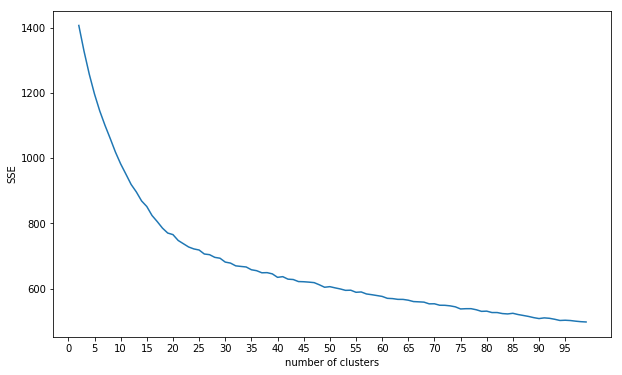

In [107]:
SSEs = []

for k in range(2,100):
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(dtm_lsa)
    labels = km.labels_
  
    SSEs.append(km.inertia_) 
    
plt.figure(1)
plt.figure(figsize=[10,6])
k_clusters = range(2,100)
plt.plot(k_clusters, SSEs)
plt.xlabel('number of clusters')
plt.ylabel('SSE')
plt.xticks(np.arange(0,100,5))

In [117]:
km = KMeans(n_clusters=25)
km.fit(dtm_lsa)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=25, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [118]:
len(df1['code']), len(clean_sentences)

(1957, 1957)

In [120]:
# pd.set_option('display.max_colwidth', -1)
clusters= pd.DataFrame(list(zip(data,km.labels_,df1['code'])),
                       columns=['description','category','code'])
# clusters.head(10)

In [121]:
unique, counts = np.unique(km.labels_, return_counts=True)
print (np.asarray((unique, counts)).T)

[[  0  89]
 [  1  86]
 [  2 162]
 [  3  40]
 [  4  69]
 [  5 124]
 [  6  26]
 [  7  59]
 [  8  78]
 [  9 130]
 [ 10  90]
 [ 11  53]
 [ 12  99]
 [ 13  88]
 [ 14  58]
 [ 15  86]
 [ 16 119]
 [ 17  42]
 [ 18  63]
 [ 19  55]
 [ 20  97]
 [ 21  56]
 [ 22  47]
 [ 23  70]
 [ 24  71]]


In [122]:
clusters.groupby(['code', 'category']).size()

code  category
0     0           6 
      1           22
      2           10
      3           7 
      4           14
      5           8 
      6           1 
      7           3 
      8           4 
      9           9 
      10          4 
      11          6 
      12          1 
      13          10
      14          5 
      15          15
      16          15
      17          3 
      18          2 
      19          1 
      20          6 
      21          7 
      22          6 
      23          9 
      24          7 
1     0           11
      1           4 
      2           22
      3           6 
      4           9 
                 .. 
4     20          9 
      21          12
      22          11
      23          27
      24          26
5     0           7 
      1           12
      2           15
      3           1 
      4           9 
      5           11
      6           4 
      7           3 
      8           10
      9           11
      10          1

In [112]:
# pd.options.display.max_rows
# pd.set_option('display.max_colwidth', -1)

# clusters.sort_values(['category'])


### TD-IDF

([<matplotlib.axis.XTick at 0x1a34548860>,
 <a list of 20 Text xticklabel objects>)

<Figure size 432x288 with 0 Axes>

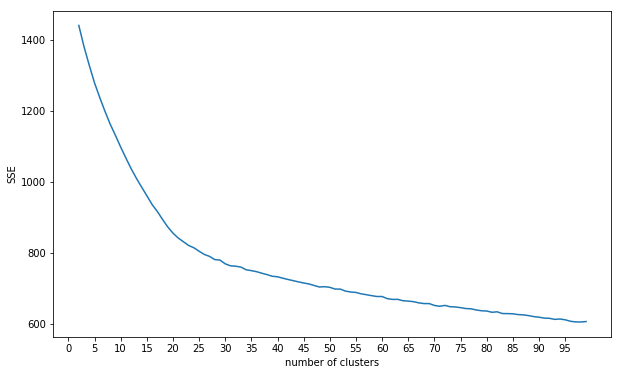

In [113]:
SSEs = []

for k in range(2,100):
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(dfm_lsa)
    labels = km.labels_
  
    SSEs.append(km.inertia_) # The SSE is just inertia, we
 # could have just said km.inertia_

plt.figure(1)
plt.figure(figsize=[10,6])
k_clusters = range(2,100)
plt.plot(k_clusters, SSEs)
plt.xlabel('number of clusters')
plt.ylabel('SSE')
plt.xticks(np.arange(0,100,5))

In [114]:
kmf = KMeans(n_clusters=25)
kmf.fit(dfm_lsa)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=25, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [123]:
clustersf= pd.DataFrame(list(zip(data,kmf.labels_,df1['code'])),
                       columns=['description','category','code'])
# clustersf

In [125]:
unique, counts = np.unique(kmf.labels_, return_counts=True)
print (np.asarray((unique, counts)).T)

[[  0  73]
 [  1  87]
 [  2  65]
 [  3  97]
 [  4 122]
 [  5  94]
 [  6  86]
 [  7  62]
 [  8  53]
 [  9  87]
 [ 10 104]
 [ 11  98]
 [ 12 101]
 [ 13  63]
 [ 14  80]
 [ 15  71]
 [ 16  70]
 [ 17  50]
 [ 18  89]
 [ 19  83]
 [ 20  54]
 [ 21  63]
 [ 22  43]
 [ 23  67]
 [ 24  95]]


In [499]:
clustersf.groupby(['category', 'code']).size()

category  code
0         0       17
          1       3 
          2       1 
          3       33
          4       3 
          5       16
1         0       1 
          1       9 
          2       61
          3       2 
          4       3 
          5       11
2         1       24
          2       8 
          3       5 
          4       8 
          5       20
3         0       22
          1       9 
          2       11
          3       12
          4       33
          5       10
4         0       10
          1       11
          2       21
          3       57
          4       12
          5       11
5         0       9 
                 .. 
20        0       3 
          1       17
          2       11
          3       6 
          4       12
          5       5 
21        0       11
          1       10
          2       12
          3       12
          4       9 
          5       9 
22        0       1 
          1       15
          2       8 
          3       1

In [529]:
clustersf[clustersf['category'] == 4]

description  category  code
7     Jehane Noujaim unveils her 2006 TED Prize wish: to bring the world together for one day a year through the power of film.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    4         2   
30    Jacqueline Novogratz applauds the world's heightened interest in Africa and poverty, but argues persuasively for a new approach.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             4         0   
35    Accepting his 2005 TED Prize, photographer Edward Burtynsky makes a wish: that his images -- stunning landscapes that document humanity's impact on the world -- help persuade millions to join a global conversation on sustainability.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     4         1   
48    With stunning photos and stories, National Geographic Explorer Wade Davis celebrates the extraordinary diversity of the world's indigenous cultures, which are disappearing from the planet at an alarming rate.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             4         3   
60    Accepting the 2007 TED Prize, Bill Clinton asks for help in bringing health care to Rwanda -- and the rest of the world.                                                                                                                              

## Input to Supervised ML

### Countvectorizer Stream

In [351]:
input2linear= pd.DataFrame(list(zip(dtm_lsa,df1['code'])),
                       columns=['extracted features','code'])
msk = np.random.rand(len(input2linear)) < 0.7
train = input2linear[msk]
test = input2linear[~msk] 

In [32]:
test.head()

extracted features  code
11  [0.40644921503702663, -0.15149375444945692, 0.02371024828351682, 0.13518760335357546, 0.06850674777746166, 0.22796433953940576, -0.07768685820542258, 0.028714274074211323, -0.04735228227135442, -0.17612135744881385, -0.2787668598455437, -0.20922275473976146, -0.1387491305921287, 0.16905794046944048, -0.37376380949001686, 0.42434248995804985, 0.1662856865759182, 0.15827348361323532, -0.3819713533748147, -0.09242653820821864]        2   
12  [0.24619843896094748, -0.11006698099434271, 0.1718805897854408, 0.45353810908575853, 0.6379444993060461, -0.061210456236661395, -0.08339870037582184, -0.08140926830675574, -0.0007562375971978894, 0.10914255254389513, 0.4140581772735906, -0.1683871801144542, -0.04655025048132756, 0.011106715377290506, -0.01626322329887845, 0.11217692240418382, 0.032790548040707676, -0.14150174953765843, -0.019981931830389904, -0.13922051266041613]  2   
14  [0.43722062020177915, -0.15823088156476994, 0.025712439082947253, 0.032033010165313354, 0.04291479276274493, -0.07540569004740151, -0.04425491302821156, -0.13581622725945788, -0.15487401577351154, 0.21770618721730206, -0.12816541162637007, -0.03786367565696606, 0.09234742018924949, 0.18409795191667916, -0.1536135537895219, -0.14680885020019033, 0.6549824763945463, -0.21342709607726582, 0.09909659236128407, 0.3049529269151547]      3   
15  [0.3858432870622903, -0.1368005412738356, 0.026394025953793306, 0.11486941509373584, 0.240697296498633, 0.009021886588849544, 0.11236694567633865, -0.15833740727417772, 0.006005919914637114, 0.10758979904926978, -0.5229146552413219, -0.055109845416764225, -0.19371626435362926, 0.1513575572396472, -0.3213913294614131, 0.4872324147933297, -0.04271956737903537, 0.12862869536417537, 0.05035020088649817, -0.11264309840321868]           0   
17  [0.4327694017677042, -0.10175864322940781, 0.26200612449029703, -0.3220352281686847, 0.13598048430941978, -0.3376794527498554, 0.11850001818248866, 0.2612504683008219, -0.011181882349988122, 0.4770845905594767, -0.24512867172898414, -0.05875454481191045, -0.20732757358406215, 0.21726755086504382, 0.01746552734916965, 0.05809396834076903, -0.07934044861654699, 0.04855599352896793, 0.13476768338472242, -0.0568337158666946]           2

In [352]:
trainexp = pd.DataFrame(train['extracted features'].values.tolist(), index= train.index)
trainexp['code'] = train['code'] 
testexp = pd.DataFrame(test['extracted features'].values.tolist(), index= test.index)
testexp['code'] = test['code'] 
testexp.head()

0         1         2         3         4         5         6         7         8         9        10        11        12        13        14        15        16        17        18        19  code
5   0.474848 -0.108406  0.138330  0.361520  0.386450  0.077388  0.009119 -0.076407  0.062391 -0.254608 -0.278754 -0.086205  0.188254  0.273496 -0.322403  0.145551 -0.040936  0.214323  0.001447  0.121849  1   
12  0.246198 -0.110067  0.171881  0.453538  0.637944 -0.061210 -0.083399 -0.081409 -0.000756  0.109143  0.414058 -0.168387 -0.046550  0.011107 -0.016263  0.112177  0.032791 -0.141502 -0.019982 -0.139221  2   
22  0.343269 -0.278387 -0.093479  0.082301 -0.318625  0.057618  0.493503 -0.222022  0.314481 -0.092392  0.269191  0.025280 -0.163760 -0.151707  0.206600  0.216459  0.140699  0.115597  0.119463 -0.155357  4   
25  0.672000 -0.126007  0.019550 -0.115701 -0.001331 -0.193272  0.071573 -0.367201 -0.246126 -0.196902  0.219546  0.058540  0.033120 -0.208802 -0.202840 -0.097256 -0.094290  0.225464 -0.150315 -0.113406  4   
27  0.381920 -0.270755 -0.182073 -0.006536 -0.284795  0.108726  0.019234 -0.020561 -0.123103  0.137114  0.178379 -0.185967  0.291292  0.110717 -0.220666  0.449301  0.358806 -0.070313  0.011549  0.268444  4

In [353]:
# Create X, y vectors
X_train = trainexp.loc[:, trainexp.columns != 'code']
X_test = testexp.loc[:, testexp.columns != 'code']

y_train = trainexp['code']
y_test = testexp['code']

In [35]:
# Gaussian NB:  
# MultinomialNB assumes that features have multinomial distribution which is 
# a generalization of the binomial distribution. Neither binomial nor multinomial 
# distributions can contain negative values.
gb = GaussianNB()
gb.fit(X_train, y_train)

# Create predictions, using trained model
# test['preds'] = tmn.predict(X_test)
scoresgbtr = gb.score(X_train, y_train)
scoresgbte = gb.score(X_test, y_test)

print ('GBtr:{}'.format(scoresgbtr))
print ('GBte:{}'.format(scoresgbte))

GBtr:0.47601476014760147
GBte:0.4485049833887043


In [36]:
#Linear SVC

svml = LinearSVC()
svml.fit(X_train, y_train)

scoressvcltr = svml.score(X_train, y_train)
scoressvclte = svml.score(X_test, y_test)

print ('LSVCtr:{}'.format(scoressvcltr))
print ('LSVCte:{}'.format(scoressvclte))

LSVCtr:0.4833948339483395
LSVCte:0.4883720930232558


In [37]:
# SVC
svc = SVC(kernel='linear').fit(X_train, y_train)

# Create predictions, using trained model
scoressvctr = svc.score(X_train, y_train)
scoressvcte = svc.score(X_test, y_test)

print ('SVCtr:{}'.format(scoressvctr))
print ('SVCte:{}'.format(scoressvcte))

SVCtr:0.4929889298892989
SVCte:0.4883720930232558


In [38]:
# Gradient Boosting
boost = GradientBoostingClassifier(n_estimators=10, max_depth=1)
boost.fit(X_train, y_train)

# Create predictions, using trained model
scoresboosttr = boost.score(X_train, y_train)
scoresboostte = boost.score(X_test, y_test)

print ('Boosttr:{}'.format(scoresboosttr))
print ('Boostte:{}'.format(scoresboostte))

Boosttr:0.4273062730627306
Boostte:0.42358803986710963


In [39]:
# Random Forest
rf = RandomForestClassifier(n_estimators=300, max_depth=2)
rf.fit(X_train, y_train)

scoresrftr = rf.score(X_train, y_train)
scoresrfte = rf.score(X_test, y_test)

print ('RFtr:{}'.format(scoresrftr))
print ('RFte:{}'.format(scoresrfte))

RFtr:0.42583025830258303
RFte:0.4169435215946844


### TFIDF Stream

In [354]:
input2linear= pd.DataFrame(list(zip(dfm_lsa,df1['code'])),
                       columns=['extracted features','code'])
msk = np.random.rand(len(input2linear)) < 0.7
train = input2linear[msk]
test = input2linear[~msk] 

In [453]:
trainexp = pd.DataFrame(train['extracted features'].values.tolist(), index= train.index)
trainexp['code'] = train['code'] 
testexp = pd.DataFrame(test['extracted features'].values.tolist(), index= test.index)
testexp['code'] = test['code'] 
testexp.head()
trainexp.shape

(1366, 21)

In [454]:
X_train = trainexp.loc[:, trainexp.columns != 'code']
X_test = testexp.loc[:, testexp.columns != 'code']

y_train = trainexp['code']
y_test = testexp['code']
len(y_test)

591

In [491]:
#Linear SVC

svml = LinearSVC()
svml.fit(X_train, y_train)

y_pred = svml.predict(X_test)
scoressvcltr = svml.score(X_train, y_train)
scoressvclte = svml.score(X_test, y_test)

print ('LSVCtr:{}'.format(scoressvcltr))
print ('LSVCte:{}'.format(scoressvclte))

LSVCtr:0.5644216691068814
LSVCte:0.5617597292724196


In [492]:
y_testcount = list(np.unique(y_test, return_counts=True)[1])

y_pred = svml.predict(X_test)
y_predcount = list(np.unique(y_pred, return_counts=True)[1])
y_testcount, y_predcount

([46, 109, 94, 156, 139, 47], [26, 103, 101, 177, 175, 9])

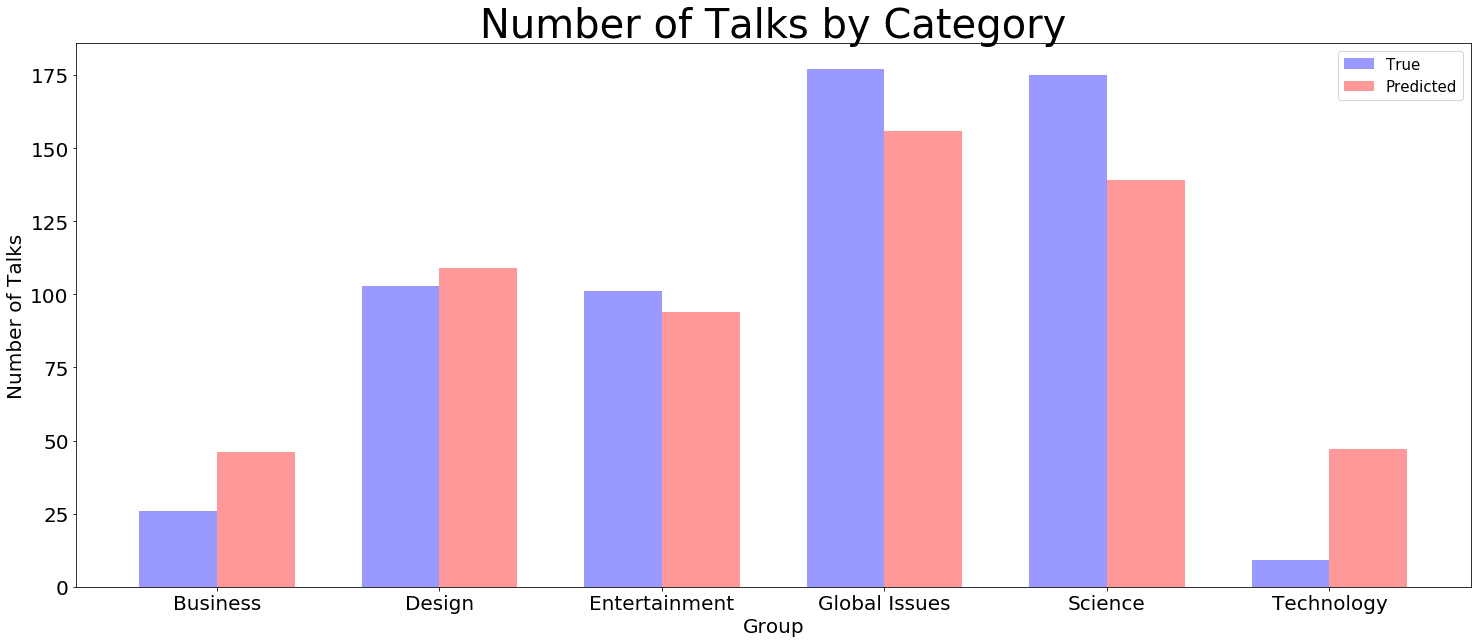

In [493]:
##### n_groups = 6

fig, ax = plt.subplots(figsize=(25,10))

index = np.arange(n_groups)
bar_width = 0.35
#width = 4
opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index, y_predcount, bar_width, 
                alpha=opacity, color='b',label='True')

rects2 = ax.bar(index+ bar_width, y_testcount, bar_width, 
                alpha=opacity, color='r',
                label='Predicted')

ax.set_xlabel('Group', fontsize = 20)
ax.set_ylabel('Number of Talks', fontsize = 20)
ax.set_title('Number of Talks by Category', fontsize = 40)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('Business', 'Design', 'Entertainment', 'Global Issues', 'Science','Technology'),fontsize = 20)

ax.set_yticklabels(range(0,200,25),fontsize = 20)
ax.legend(fontsize = 15)

#fig.tight_layout()

plt.show()

In [495]:
# Optimized Linear SVC
svml = LinearSVC()
param_grid = {'C': [1.0, 10,100,1000]}

svmlg = GridSearchCV(svml, param_grid=param_grid, cv =10)  
svmlg.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(svmlg.best_params_)

scoressvmlgtr = svmlg.score(X_train, y_train)
scoressvmlgte = svmlg.score(X_test, y_test)
print ('LSVCgtr:{}'.format(scoressvmlgtr))
print ('LSVCgte:{}'.format(scoressvmlgte))

Best parameters set found on development set:

{'C': 1.0}
LSVCgtr:0.5644216691068814
LSVCgte:0.5617597292724196


In [45]:
# SVC
svc = SVC(kernel='linear').fit(X_train, y_train)

# Create predictions, using trained model
scoressvctr = svc.score(X_train, y_train)
scoressvcte = svc.score(X_test, y_test)

print ('SVCtr:{}'.format(scoressvctr))
print ('SVCte:{}'.format(scoressvcte))

SVCtr:0.590539541759054
SVCte:0.5364238410596026


In [46]:
# SVC
svcr = SVC(kernel='rbf').fit(X_train, y_train)

# Create predictions, using trained model
scoressvcrtr = svcr.score(X_train, y_train)
scoressvcrte = svcr.score(X_test, y_test)

print ('SVCrtr:{}'.format(scoressvcrtr))
print ('SVCrte:{}'.format(scoressvcrte))

SVCrtr:0.5447154471544715
SVCrte:0.5314569536423841


In [345]:
param_grid = {'C': [.1,1.0, 10.],
              'degree':[2,3],
              'kernel':['rbf'], # radial basis function
              'gamma':[1e-3,1,10,100]}
# svcr = make_pipeline(PolynomialFeatures(degree))
# svcr = SVC(kernel='rbf').fit(X_train, y_train)
svmg = GridSearchCV(svcr, param_grid=param_grid, cv =10)
svmg.fit(X_train, y_train)

y_pred_train = svmg.predict(X_train)
y_pred_test= svmg.predict(X_test)

print("Best parameters set found on development set:")
print()
print(svmg.best_params_)


   
print('Test Accuracy:',metrics.accuracy_score(y_test, y_pred_test))
print('Train Accuracy:',metrics.accuracy_score(y_train, y_pred_train))

Test Accuracy: 0.5417439703153989
Train Accuracy: 0.68688293370945


In [48]:
# Random Forest
rf = RandomForestClassifier(n_estimators=300, max_depth=2)
rf.fit(X_train, y_train)

scoresrftr = rf.score(X_train, y_train)
scoresrfte = rf.score(X_test, y_test)

print ('RFtr:{}'.format(scoresrftr))
print ('RFte:{}'.format(scoresrfte))

RFtr:0.5092387287509239
RFte:0.4602649006622517


In [49]:
# Gradient Boosting
boost = GradientBoostingClassifier(n_estimators=10, max_depth=1)
boost.fit(X_train, y_train)

# Create predictions, using trained model
scoresboosttr = boost.score(X_train, y_train)
scoresboostte = boost.score(X_test, y_test)

print ('Boosttr:{}'.format(scoresboosttr))
print ('Boostte:{}'.format(scoresboostte))

Boosttr:0.500369549150037
Boostte:0.48509933774834435


In [436]:
y_predseries = pd.Series(y_pred, index = y_test.index.values)

In [477]:
y_pred_df = pd.DataFrame(y_predseries)

y_test_df = pd.DataFrame(y_test)

In [494]:
#df2 = pd.merge(y_test_df, y_pred_df, how = 'right', right_index=True, left_index=True)
df2

code  0
1     2     1
6     3     1
11    2     2
12    2     1
14    3     1
18    2     3
20    4     3
21    3     3
23    0     4
28    4     4
30    0     3
37    2     3
38    4     4
41    4     4
44    3     4
45    2     2
46    0     3
48    3     3
58    3     3
61    1     1
62    4     3
68    1     1
70    1     4
71    1     1
77    3     3
78    3     3
82    2     2
87    2     2
97    3     1
98    4     4
...  ..    ..
1832  4     4
1833  4     2
1835  1     4
1846  4     4
1854  1     1
1857  3     3
1865  4     4
1866  4     4
1869  4     4
1872  3     3
1873  0     0
1876  3     3
1886  4     3
1895  5     3
1899  4     4
1903  4     4
1905  4     4
1909  1     1
1911  4     4
1912  5     3
1921  1     1
1923  5     3
1924  4     4
1926  4     4
1935  3     3
1937  5     4
1939  4     4
1951  1     1
1952  1     3
1955  4     1

[591 rows x 2 columns]

In [488]:
temp1 = list(np.unique(df2['code'], return_counts=True))
temp1  ([46, 109, 94, 156, 139, 47], [26, 103, 101, 177, 175, 9])

[array([0, 1, 2, 3, 4, 5]), array([ 46, 109,  94, 156, 139,  47])]

## LDA

### CountVectorizer/Bag of Words

In [140]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1)]]


In [51]:
corpus

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1)],
 [(20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1)],
 [(41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1)],
 [(61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1)],
 [(1, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1)],
 [(37, 1),
  (86, 1),
  (87, 1),
  (88, 1),
  (89

In [52]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('address', 1),
  ('al_gore', 1),
  ('brand', 1),
  ('buy', 1),
  ('climate_change', 1),
  ('exude', 1),
  ('global_warming', 1),
  ('hot', 1),
  ('humanity', 1),
  ('humor', 1),
  ('hybrid', 1),
  ('immediately', 1),
  ('inconvenient', 1),
  ('individual', 1),
  ('invent', 1),
  ('name', 1),
  ('new', 1),
  ('spell', 1),
  ('truth', 1),
  ('way', 1)]]

In [139]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [54]:
print(lda_model.print_topics(num_words=5))

[(0, '0.012*"even" + 0.010*"earth" + 0.010*"want" + 0.009*"space" + 0.009*"world"'), (1, '0.010*"first" + 0.008*"government" + 0.008*"play" + 0.007*"value" + 0.007*"artist"'), (2, '0.013*"may" + 0.013*"think" + 0.012*"know" + 0.010*"time" + 0.009*"technology"'), (3, '0.011*"study" + 0.011*"idea" + 0.010*"new" + 0.010*"science" + 0.009*"scientist"'), (4, '0.020*"world" + 0.019*"people" + 0.016*"work" + 0.015*"help" + 0.012*"live"')]


In [66]:
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
# vis

### Tdidf

In [147]:
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [539]:
# Build LDA model
ldat_model = gensim.models.ldamodel.LdaModel(corpus=corpus_tfidf,
                                           id2word=id2word,
                                           num_topics=25, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [164]:
print(ldat_model.print_topics(num_words=5))

[(0, '0.000*"pencil" + 0.000*"jha" + 0.000*"suzuki" + 0.000*"counterfeit" + 0.000*"stampede"'), (1, '0.003*"help" + 0.003*"study" + 0.003*"create" + 0.002*"brain" + 0.002*"scientist"'), (2, '0.003*"world" + 0.003*"work" + 0.002*"people" + 0.002*"think" + 0.002*"live"')]


In [510]:
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(ldat_model, corpus, id2word)
# vis

In [540]:

vis = pyLDAvis.gensim.prepare(ldat_model, corpus, id2word)
pyLDAvis.show(vis)


/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))



Note: if you're in the IPython notebook, pyLDAvis.show() is not the best command
      to use. Consider using pyLDAvis.display(), or pyLDAvis.enable_notebook().
      See more information at http://pyLDAvis.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8894/    [Ctrl-C to exit]


127.0.0.1 - - [23/Aug/2018 21:22:32] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [23/Aug/2018 21:22:32] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [23/Aug/2018 21:22:32] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [23/Aug/2018 21:22:32] "GET /LDAvis.js HTTP/1.1" 200 -



stopping Server...
